In [45]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch.nn.functional as F

# 1. ANN Regression

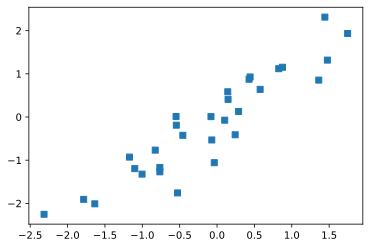

In [2]:
# create data

N = 30
x = torch.randn(N,1)
y = x + torch.randn(N,1)/2

# and plot
plt.plot(x,y,'s')
plt.show()

In [4]:
# build model
ANNreg = nn.Sequential(
    nn.Linear(1,1),  # input layer
    nn.ReLU(),       # activation function
    nn.Linear(1,1)   # output layer
    )
# learning rate
learningRate = .05

# loss function
lossfun = nn.MSELoss()

# optimizer (the flavor of gradient descent to implement)
optimizer = torch.optim.SGD(ANNreg.parameters(),lr=learningRate)

# train the model
numepochs = 500
losses = torch.zeros(numepochs)


## Train the model!
for epochi in range(numepochs):

  # forward pass
  yHat = ANNreg(x)

  # compute loss
  loss = lossfun(yHat,y)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

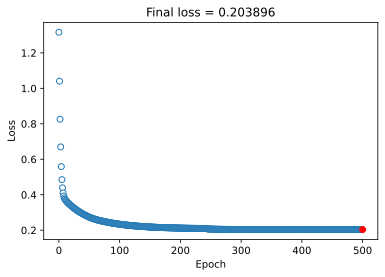

In [5]:
# show the losses

# manually compute losses
# final forward pass
predictions = ANNreg(x)

# final loss (MSE)
testloss = (predictions-y).pow(2).mean()

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.plot(numepochs,testloss.detach(),'ro')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final loss = %g' %testloss.item())
plt.show()

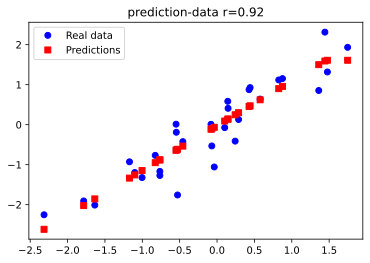

In [6]:
# plot the data
plt.plot(x,y,'bo',label='Real data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')
plt.title(f'prediction-data r={np.corrcoef(y.T,predictions.detach().T)[0,1]:.2f}')
plt.legend()
plt.show()

# 2. ANN Classification

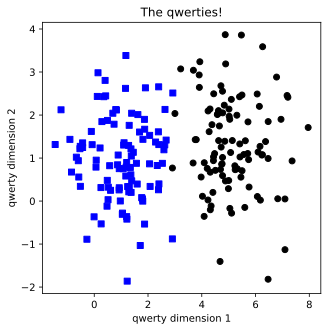

In [7]:
# create data

nPerClust = 100
blur = 1

A = [  1, 1 ]
B = [  5, 1 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

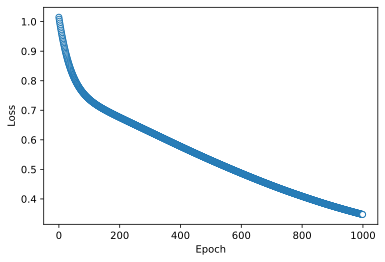

In [18]:
# build the model
ANNclassify = nn.Sequential(
    nn.Linear(2,1),   # input layer
    nn.ReLU(),        # activation unit
    nn.Linear(1,1),   # output unit
    nn.Sigmoid(),     # final activation unit (here for conceptual reasons; in practice, better to use BCEWithLogitsLoss)
      )

# other model features

learningRate = .01

# loss function
lossfun = nn.BCELoss()
# Note: You'll learn in the "Metaparameters" section that it's better to use BCEWithLogitsLoss, but this is OK for now.

# optimizer
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)


# train the model
numepochs = 1000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

  # forward pass
  yHat = ANNclassify(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

# show the losses

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
# compute the predictions

# manually compute losses
# final forward pass
predictions = ANNclassify(data)

predlabels = predictions>.5

# find errors
misclassified = np.where(predlabels != labels)[0]

# total accuracy
totalacc = 100-100*len(misclassified)/(2*nPerClust)

print('Final accuracy: %g%%' %totalacc)


Final accuracy: 88.5%


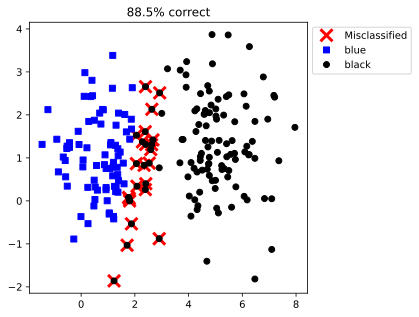

In [20]:
# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=12,markeredgewidth=3)
plt.plot(data[np.where(~predlabels)[0],0],data[np.where(~predlabels)[0],1],'bs')
plt.plot(data[np.where(predlabels)[0],0] ,data[np.where(predlabels)[0],1] ,'ko')

plt.legend(['Misclassified','blue','black'],bbox_to_anchor=(1,1))
plt.title(f'{totalacc}% correct')
plt.show()

# 3. Learning Rate

### 3.1 Functions to build and train the model

In [21]:
def createANNmodel(learningRate):

  # model architecture
  ANNclassify = nn.Sequential(
      nn.Linear(2,1),   # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(1,1),   # output unit
      #nn.Sigmoid(),    # final activation unit (not needed b/c we use BCEWithLogitsLoss)
        )

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

  # model output
  return ANNclassify,lossfun,optimizer

In [22]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel):

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  
  
  # final forward pass
  predictions = ANNmodel(data)
    
  # compute the predictions and report accuracy
  # NOTE: shouldn't it be predictions>.5??
  totalacc = 100*torch.mean(((predictions>0) == labels).float())
  
  return losses,predictions,totalacc

### 3.2 Test the new code by running it once

Final accuracy: 93%


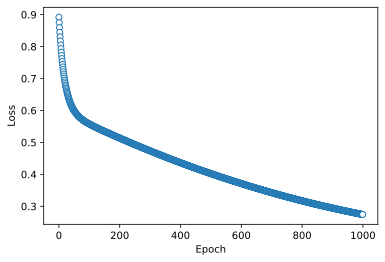

In [23]:
# create everything
ANNclassify,lossfun,optimizer = createANNmodel(.01)

# run it
losses,predictions,totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

### 3.3 Apply function on the experiment

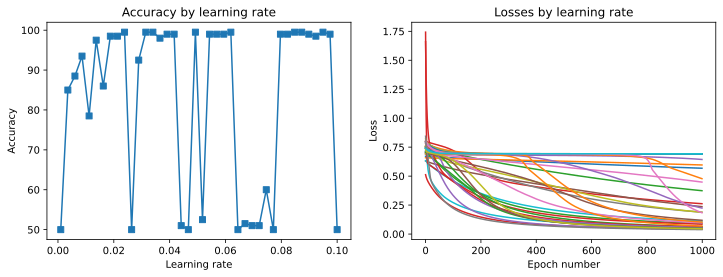

In [24]:
# the set of learning rates to test
learningrates = np.linspace(.001,.1,40)

# initialize results output
accByLR = []
allLosses = np.zeros((len(learningrates),numepochs))


# loop through learning rates
for i,lr in enumerate(learningrates):
  
  # create and run the model
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)
  allLosses[i,:] = losses.detach()


# plot the results
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

### 3.4 Run a meta-experiment

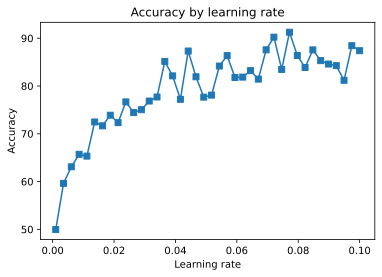

In [25]:
# run a "meta-experiment" by repeating the experiment N times
#  (different random weight initializations each time)
# note: this cell takes ~7 mins.

# number of times to iterate through the experiment
numExps = 50

# matrix to store all results
accMeta = np.zeros((numExps,len(learningrates)))

# fewer epochs to reduce computation time
numepochs = 500

# now for the experiment
for expi in range(numExps):
  for i,lr in enumerate(learningrates):
    
    # create and run the model
    ANNclassify,lossfun,optimizer = createANNmodel(lr)
    losses,predictions,totalacc = trainTheModel(ANNclassify)

    # store the results
    accMeta[expi,i] = totalacc



# now plot the results, averaged over experiments
plt.plot(learningrates,np.mean(accMeta,axis=0),'s-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate')
plt.show()

# 4. Multiple Outputs

### 4.1 Import and transform the data

In [26]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

### 4.2 Create the ANN model

In [27]:
# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,3),   # output layer
      )

# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ANNiris(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy
  matches = torch.argmax(yHat,axis=1) == labels # booleans (false/true)
  matchesNumeric = matches.float()              # convert to numbers (0/1)
  accuracyPct = 100*torch.mean(matchesNumeric)  # average and x100 
  ongoingAcc.append( accuracyPct )              # add to list of accuracies



# final forward pass
predictions = ANNiris(data)
  
predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == labels).float())

Final accuracy: 98%


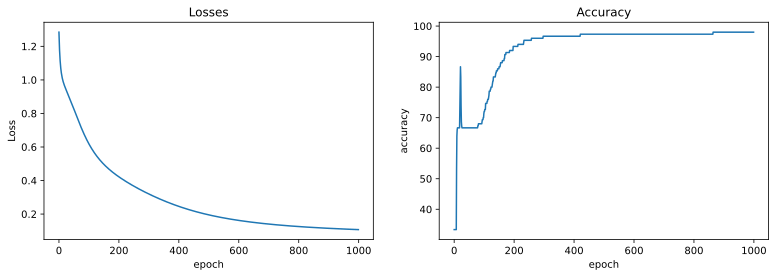

In [28]:
# report accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent

In [29]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
torch.sum(sm(yHat),axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

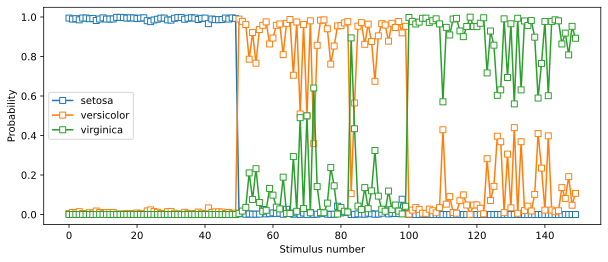

In [30]:
# plot the raw model outputs

fig = plt.figure(figsize=(10,4))

plt.plot(sm(yHat).detach(),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

# 5. n Hidden Units 

### 5.1 Create and Train the model

In [31]:
# Note the input into the function!
def createIrisModel(nHidden):

  # model architecture (with number of units soft-coded!)
  ANNiris = nn.Sequential(
      nn.Linear(4,nHidden),      # input layer
      nn.ReLU(),                 # activation unit
      nn.Linear(nHidden,nHidden),# hidden layer
      nn.ReLU(),                 # activation unit
      nn.Linear(nHidden,3),      # output unit
      #nn.Softmax(dim=1),        # final activation unit (here for conceptual purposes, note the CEL function)
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

In [32]:
# a function to train the model

def trainTheModel(ANNiris):

  # initialize losses
  losses = torch.zeros(numepochs)
  ongoingAcc = []

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNiris(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final forward pass
  predictions = ANNiris(data)
    
  predlabels = torch.argmax(predictions,axis=1)
  return 100*torch.mean((predlabels==labels).float())

### 5.2 Test the model

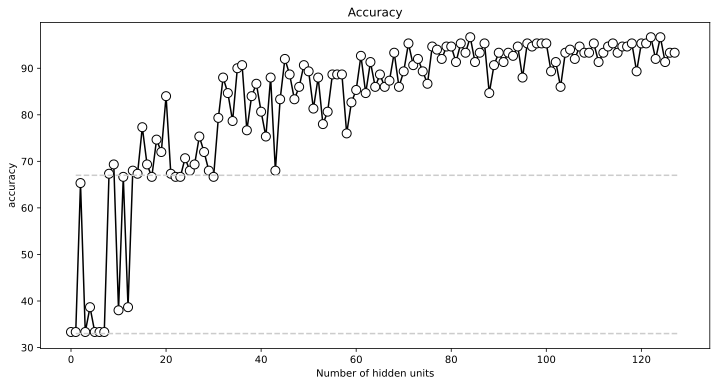

In [33]:
numepochs  = 150
numhiddens = np.arange(1,129)
accuracies = []

for nunits in numhiddens:

  # create a fresh model instance
  ANNiris,lossfun,optimizer = createIrisModel(nunits)

  # run the model
  acc = trainTheModel(ANNiris)
  accuracies.append( acc )


# report accuracy
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(accuracies,'ko-',markerfacecolor='w',markersize=9)
ax.plot(numhiddens[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numhiddens[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()


# 6. Number of Parameters

In [34]:
# build two models

widenet = nn.Sequential(
    nn.Linear(2,4),  # hidden layer
    nn.Linear(4,3),  # output layer
    )


deepnet = nn.Sequential(
    nn.Linear(2,2),  # hidden layer
    nn.Linear(2,2),  # hidden layer
    nn.Linear(2,3),  # output layer
    )

# print them out to have a look
print(widenet)
print(' ')
print(deepnet)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=3, bias=True)
)
 
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=3, bias=True)
)


In [35]:
# check out the parameters
for p in deepnet.named_parameters():
  print(p)
  print(' ')

# count the number of nodes ( = the number of biases)

# named_parameters() is an iterable that returns the tuple (name,numbers)
numNodesInWide = 0
for p in widenet.named_parameters():
  if 'bias' in p[0]:
    numNodesInWide += len(p[1])

numNodesInDeep = 0
for paramName,paramVect in deepnet.named_parameters():
  if 'bias' in paramName:
    numNodesInDeep += len(paramVect)


print('There are %s nodes in the wide network.' %numNodesInWide)
print('There are %s nodes in the deep network.' %numNodesInDeep)

# just the parameters
for p in widenet.parameters():
  print(p)
  print(' ')

# now count the total number of trainable parameters
nparams = 0
for p in widenet.parameters():
  if p.requires_grad:
    print('This piece has %s parameters' %p.numel())
    nparams += p.numel()

print('\n\nTotal of %s parameters'%nparams)

# btw, can also use list comprehension

nparams = np.sum([ p.numel() for p in widenet.parameters() if p.requires_grad ])
print('Widenet has %s parameters'%nparams)

nparams = np.sum([ p.numel() for p in deepnet.parameters() if p.requires_grad ])
print('Deepnet has %s parameters'%nparams)

# A nice simple way to print out the model info.
from torchsummary import summary
summary(widenet,(1,2))

('0.weight', Parameter containing:
tensor([[ 0.2791, -0.1191],
        [-0.5893,  0.0881]], requires_grad=True))
 
('0.bias', Parameter containing:
tensor([ 0.4047, -0.6037], requires_grad=True))
 
('1.weight', Parameter containing:
tensor([[ 0.2090, -0.0060],
        [ 0.4871,  0.6824]], requires_grad=True))
 
('1.bias', Parameter containing:
tensor([0.2361, 0.6844], requires_grad=True))
 
('2.weight', Parameter containing:
tensor([[ 0.5138,  0.5355],
        [-0.6735, -0.5831],
        [ 0.6911, -0.6016]], requires_grad=True))
 
('2.bias', Parameter containing:
tensor([ 0.3379,  0.3265, -0.0380], requires_grad=True))
 
There are 7 nodes in the wide network.
There are 7 nodes in the deep network.
Parameter containing:
tensor([[-0.1539,  0.3819],
        [ 0.0110,  0.0137],
        [-0.1227, -0.4436],
        [-0.4708, -0.2869]], requires_grad=True)
 
Parameter containing:
tensor([-0.0948,  0.5550,  0.2136, -0.1108], requires_grad=True)
 
Parameter containing:
tensor([[-0.2587, -0.1357

# 7. Define ANN class

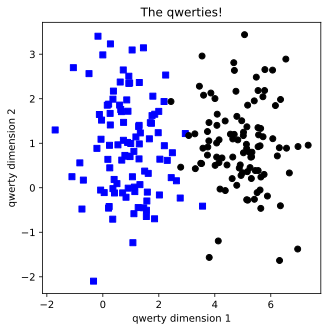

In [39]:
# create data

nPerClust = 100
blur = 1

A = [  1, 1 ]
B = [  5, 1 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [40]:
### define the class

class theClass4ANN(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(2,1)
    
    ### output layer
    self.output = nn.Linear(1,1)

  # forward pass
  def forward(self,x):

    # pass through the input layer
    x = self.input(x)

    # apply relu
    x = F.relu( x )

    # output layer
    x = self.output(x)
    x = torch.sigmoid(x)

    return x


### create an instance of the class
ANNclassify = theClass4ANN()

In [41]:
# other model features

learningRate = .01

# loss function
lossfun = nn.BCELoss()
# Note: You'll learn in the "Metaparameters" section that it's better to use BCEWithLogitsLoss, but this is OK for now.

# optimizer
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)


In [46]:
# train the model
numepochs = 1000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

  # forward pass
  yHat = ANNclassify(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [47]:
# compute the predictions

# manually compute losses
# final forward pass
predictions = ANNclassify(data)

predlabels = predictions>.5

# find errors
misclassified = np.where(predlabels != labels)[0]

# total accuracy
totalacc = 100-100*len(misclassified)/(2*nPerClust)

print('Final accuracy: %g%%' %totalacc)


Final accuracy: 50%


# Reference

These are codes learned from the Udemy

COURSE: A deep understanding of deep learning

TEACHER: Mike X Cohen, sincxpress.com

COURSE URL: udemy.com/course/dudl/?couponCode=202109